In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.feature_selection import chi2
from torch.utils.data import DataLoader, Dataset
import torch

import nltk
from nltk.tokenize import word_tokenize

In [2]:
file_name = os.path.join(os.getcwd(),  'sentiment_analysis.csv')
df = pd.read_csv(file_name)
df = df.drop(columns=['id'])
df.head()

,label,tweet
0,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,0,Finally a transparant silicon case ^^ Thanks t...
2,0,We love this! Would you go? #talk #makememorie...
3,0,I'm wired I know I'm George I was made that wa...
4,1,What amazing service! Apple won't even talk to...


In [3]:
def clean(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    # text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\n',' ', text)  # Remove line breaks
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation
    text = text.lower()  # Lowercase

    filtered_text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

    return filtered_text

# Function to extract hashtags from a tweet
def extract_hashtags(tweet):
    hashtags = re.findall(r'#(\w+)', tweet)
    return hashtags

# Apply the function to extract hashtags and create a new column
df['hashtags'] = df['tweet'].apply(extract_hashtags)

df['cleaned_tweet'] = df['tweet'].apply(clean)


Next: TF-IDF Vectorization

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use this function to generate tokens for each character, instead of whole sentences
def tokenize_text(text):
    return word_tokenize(text)

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_text)

# Fit-transform the cleaned tweet data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_tweet'])

# Convert the TF-IDF matrix to a pandas DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Optionally, concatenate the TF-IDF DataFrame with the original DataFrame
# This can be helpful if you want to retain other information from the original DataFrame
# For example:
# combined_df = pd.concat([df, tfidf_df], axis=1)

# Print the shape of the TF-IDF matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)

# Optionally, print the TF-IDF matrix DataFrame
# print(tfidf_df.head())


c:\Users\Alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF matrix shape: (7920, 16292)


Run Chi-squared test to determine the relevance of each word to the labels

In [11]:

# Perform Chi-squared test
chi2_stat, p_values = chi2(tfidf_matrix, df['label'])

# Create a DataFrame to store the results
chi2_results = pd.DataFrame({
    'feature': tfidf_vectorizer.get_feature_names_out(),
    'chi2_stat': chi2_stat,
    'p_values': p_values
})

# Sort the DataFrame by p-values
chi2_results_sorted = chi2_results.sort_values(by='p_values')

# Print the top significant features
print("Top significant features:")
print(chi2_results_sorted.head())


Top significant features:
       feature  chi2_stat      p_values
4987   fucking  80.961106  2.302042e-19
5877      hate  73.158711  1.196324e-17
564      apple  69.018530  9.754264e-17
15159   update  67.992615  1.641090e-16
4975      fuck  61.411456  4.631080e-15


Visualizations generated below

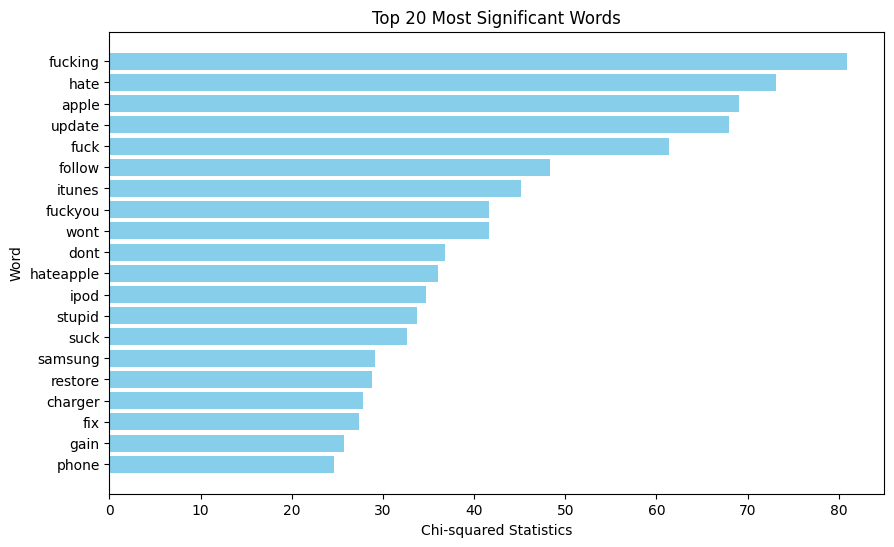

In [12]:
# Select the top 20 most significant words
top_words = chi2_results_sorted.head(20)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_words['feature'], top_words['chi2_stat'], color='skyblue')
plt.xlabel('Chi-squared Statistics')
plt.ylabel('Word')
plt.title('Top 20 Most Significant Words')
plt.gca().invert_yaxis()  # Invert y-axis to have the most significant words at the top
plt.show()


Determine which of the labels, positive or negative, each of these words is associated with

In [15]:
# Calculate the total number of positive and negative tweets
total_positive_tweets = df[df['label'] == 1].shape[0]
total_negative_tweets = df[df['label'] == 0].shape[0]
# Calculate the total number of occurrences of each word in positive and negative tweets
word_occurrences_positive = tfidf_matrix[df['label'] == 1].sum(axis=0)
word_occurrences_negative = tfidf_matrix[df['label'] == 0].sum(axis=0)

# Calculate the relative frequency of each word in positive and negative tweets
top_words['relative_freq_positive'] = top_words.apply(lambda row: word_occurrences_positive[0, tfidf_vectorizer.vocabulary_[row['feature']]] / total_positive_tweets, axis=1)
top_words['relative_freq_negative'] = top_words.apply(lambda row: word_occurrences_negative[0, tfidf_vectorizer.vocabulary_[row['feature']]] / total_negative_tweets, axis=1)

# Determine the sentiment associated with each word based on relative frequency
top_words['sentiment'] = np.where(top_words['relative_freq_positive'] > top_words['relative_freq_negative'], 1, 0)

# Print the top words along with their associated sentiment
print("Top 20 most significant words and their associated sentiment:")
print(top_words[['feature', 'sentiment']])


Top 20 most significant words and their associated sentiment:
         feature  sentiment
4987     fucking          1
5877        hate          1
564        apple          1
15159     update          1
4975        fuck          1
4726      follow          0
7232      itunes          1
5014     fuckyou          1
15899       wont          1
3633        dont          1
5880   hateapple          1
7135        ipod          1
13798     stupid          1
13844       suck          1
12446    samsung          0
12094    restore          1
2302     charger          1
4633         fix          1
5087        gain          0
10427      phone          1


C:\Users\Alexa\AppData\Local\Temp\ipykernel_11588\3875307169.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words['relative_freq_positive'] = top_words.apply(lambda row: word_occurrences_positive[0, tfidf_vectorizer.vocabulary_[row['feature']]] / total_positive_tweets, axis=1)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_11588\3875307169.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words['relative_freq_negative'] = top_words.apply(lambda row: word_occurrences_negative[0, tfidf_vectorizer

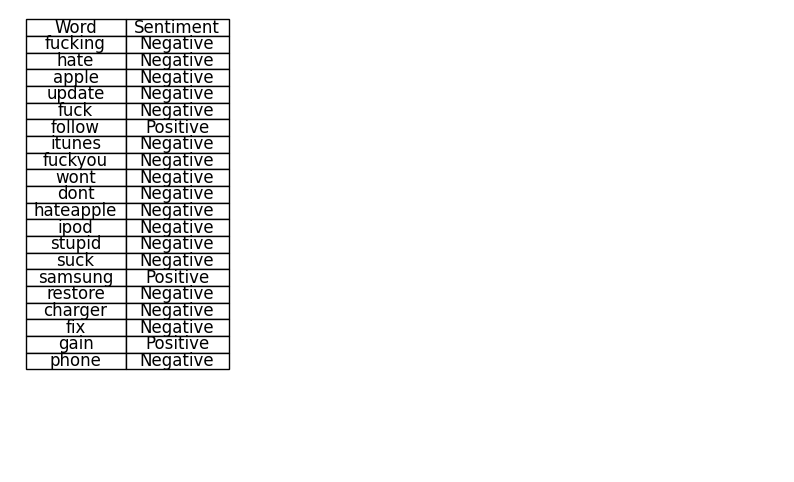

In [19]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes
ax.axis('off')

# Create a table
table_data = [[word, 'Positive' if label == 0 else 'Negative'] for word, label in zip(top_words['feature'], top_words['sentiment'])]
table = ax.table(cellText=table_data, colLabels=['Word', 'Sentiment'], cellLoc='center', loc='upper left')

# Customize the table properties
table.auto_set_font_size(False)
table.set_fontsize(12)

# Adjust the table layout
table.auto_set_column_width(col=list(range(len(table_data[0]))))

# Show the table
plt.show()


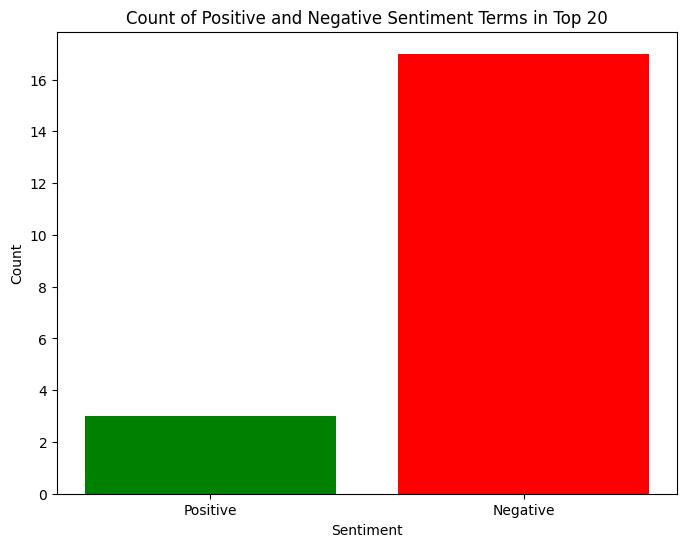

In [20]:
import matplotlib.pyplot as plt

# Count the occurrences of positive and negative sentiment terms in the top 20
positive_count = (top_words['sentiment'] == 0).sum()
negative_count = (top_words['sentiment'] == 1).sum()

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_count, negative_count], color=['green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Positive and Negative Sentiment Terms in Top 20')
plt.show()
